In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import *
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.rescale import rescale_terms, get_numbers_of_bosonic_operators_in_terms
from src.lobe._utils import get_basis_of_full_system
import matplotlib.pyplot as plt

/Users/carterm.gustin/anaconda3/envs/phd/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


\begin{equation}
H = \sum_n^{\Lambda_{f}} b_n^\dagger b_n + \sum_n^{\Lambda_{af}} d_n^\dagger d_n + \sum_n^{\Lambda_{b}} a_n^\dagger a_n + \sum_{i,j,k,l}^{\Lambda_b} a_i^\dagger a_j^\dagger a_k a_l + \sum_{i,j,k}^{\Lambda_f, \Lambda_{af}, \Lambda_b} \left(b_i^\dagger d_j^\dagger a_k + b_i d_j a_k^\dagger \right)
\end{equation}

In [2]:
Lambda_f = Lambda_af = 2
Lambda_b = 2
max_occ = 3

In [3]:
Hfree = (
    ParticleOperator('b0^ b0')
    + ParticleOperator('b1^ b1')
    + ParticleOperator('d0^ d0')
    + ParticleOperator('d1^ d1')
    + ParticleOperator('a0^ a0')
    + ParticleOperator('a1^ a1')
)


In [4]:
H_four_pt_gluon = ParticleOperator({})

for i in range(Lambda_b):
    for j in range(Lambda_b):
        for k in range(Lambda_b):
            for l in range(Lambda_b):
                four_pt_str = 'a' + str(i) + '^ ' + 'a' + str(j) + '^ ' + 'a' + str(k) + ' a' + str(l)
                H_four_pt_gluon += ParticleOperator(four_pt_str)

In [5]:
H_pair_production = ParticleOperator({})
H_pair_annihilation = ParticleOperator({})

for i in range(Lambda_f ):
    for j in range(Lambda_af ):
        for k in range(Lambda_b ):
            production_str = 'b' + str(i) + "^ " + 'd' + str(j) + "^ " + 'a' + str(k)
            annihilation_str = 'b' + str(i) + ' d' + str(j) + ' a' + str(k) + "^"
            H_pair_production += ParticleOperator(production_str)
            H_pair_annihilation += ParticleOperator(annihilation_str)

In [6]:
hamiltonian = Hfree + H_pair_annihilation + H_pair_production #+ H_four_pt_gluon

In [7]:
hamiltonian.display()

<IPython.core.display.Latex object>

In [8]:
len(hamiltonian)

22

In [9]:
basis = get_fock_basis(hamiltonian, max_occ)

In [10]:
ham_matrix = generate_matrix(hamiltonian, basis)

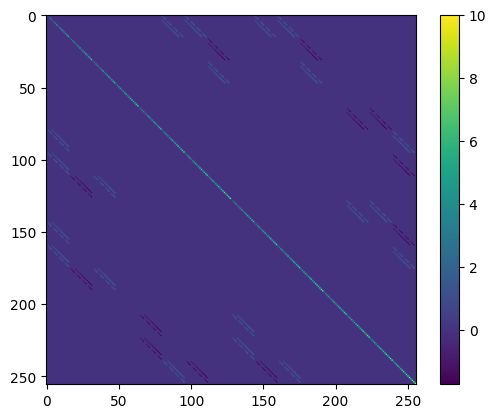

In [11]:
plt.imshow(ham_matrix)
plt.colorbar()

In [12]:
circuit, unitary, matrix = lobe_circuit(hamiltonian, max_occ, return_unitary=False)

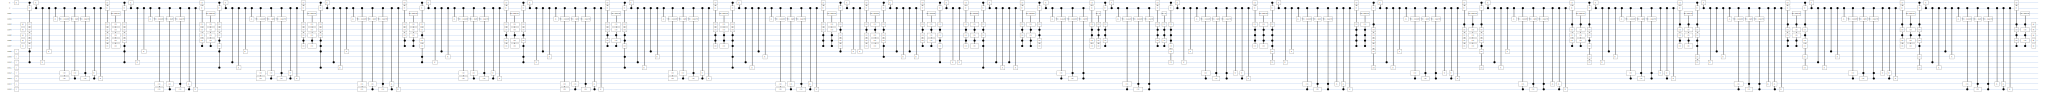

In [13]:
SVGCircuit(circuit)

In [14]:
Lambda_f = 2

In [15]:
Hpair = ParticleOperator({})
Htwo_body = ParticleOperator({})

for i in range(Lambda_f):
    for j in range(Lambda_f):
        pair_str = 'b' + str(i) + '^ ' + 'b' + str(j)
        Hpair += ParticleOperator(pair_str)
        for k in range(Lambda_f):
            for l in range(Lambda_f):
                if i < j and l < k:
                    two_body_str = 'b' + str(i) + '^ ' + 'b' + str(j) + '^ ' + 'b' + str(k) + ' b' + str(l)
                    Htwo_body += ParticleOperator(two_body_str)

In [16]:
H = Hpair + Htwo_body

circuit, _, _ = lobe_circuit(H)

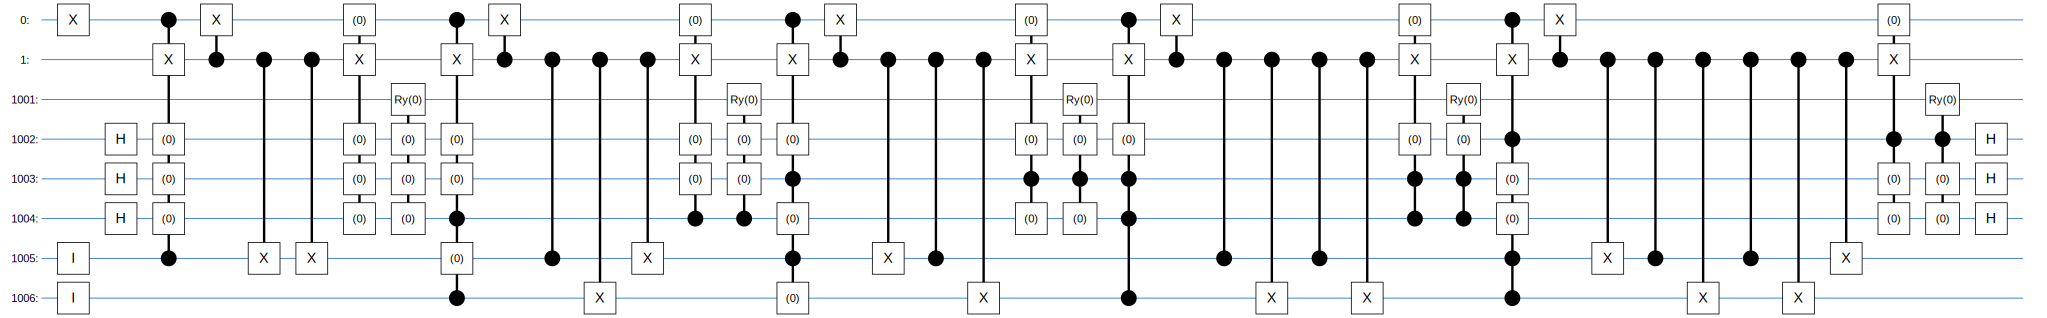

In [17]:
SVGCircuit(circuit)

In [2]:
H = 1/48 * ParticleOperator('a0^ a0^ b0^ d0') + 1/24 * ParticleOperator('a0^ a0 d0^') + 1/16 * ParticleOperator('b0^ d0^ d0')

In [3]:
H

0.020833333333333332 * a0^ a0^ b0^ d0
0.041666666666666664 * a0^ a0 d0^
0.0625 * b0^ d0^ d0

In [4]:
circuit, _, _ = lobe_circuit(H, max_bose_occ=3,decompose=True)

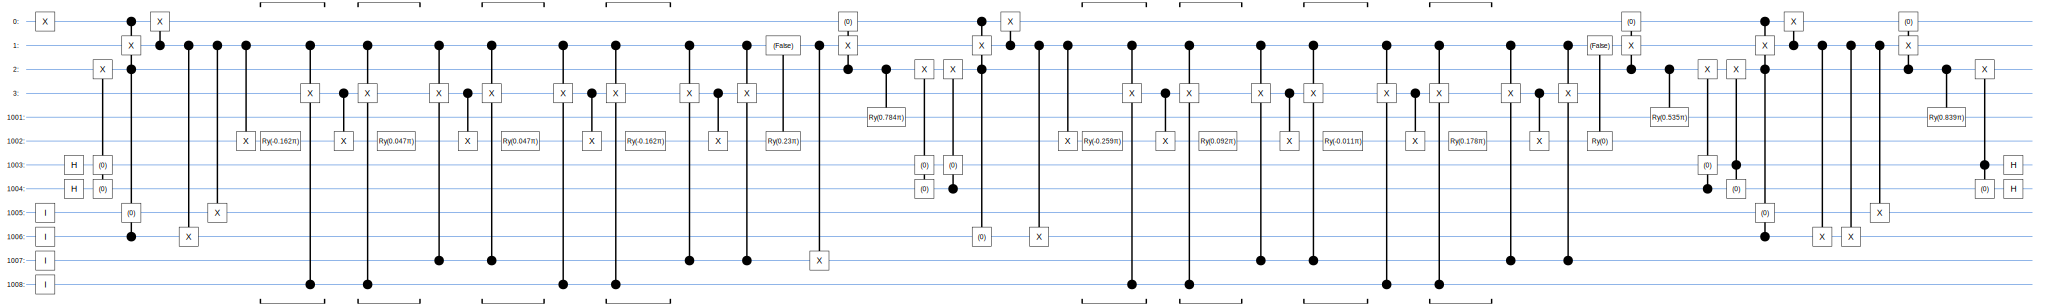

In [5]:
SVGCircuit(circuit)

# Quartic Oscillator

In [22]:
renormalized_quartic_oscillator_hamiltonian = ParticleOperator({
    'a0^ a0^ a0^ a0': 2.849565686667622,
    'a0^ a0^': 3.5923247590513974,
    'a0^ a0^ a0 a0': -5.536050711865201,
    'a0^ a0': 11.737092068070014,
    'a0^ a0 a0 a0': 2.849565686667622,
    #' ': 2.4780255664185606, # remove identity term
    'a0 a0': 3.5923247590513974,
    'a0^ a0^ a0^ a0 a0 a0': 3.9998612759007717,
    'a0^ a0^ a0 a0 a0 a0': 3.5581095542809806,
})

In [23]:
maximum_occupation_number = 3

In [24]:
circuit, unitary, _ = lobe_circuit(renormalized_quartic_oscillator_hamiltonian, max_bose_occ=maximum_occupation_number, decompose=True)

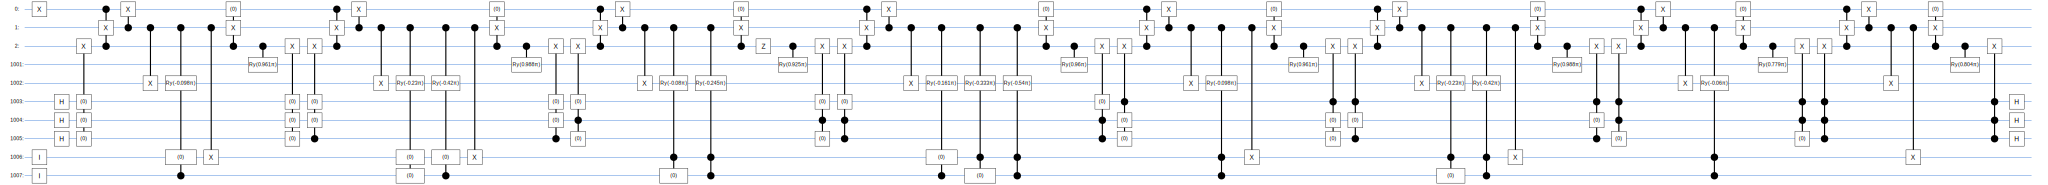

In [25]:
SVGCircuit(circuit)

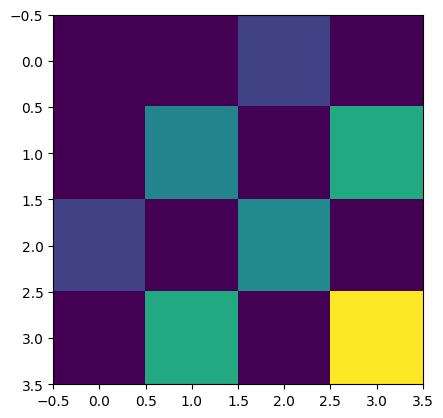

In [26]:
plt.imshow(np.real(unitary))

In [27]:
g = 1.0

In [28]:
Hfull = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4

In [38]:
Hfull.normal_order()

1.0 * a0^ a0^ a0^ a0^
4.0 * a0^ a0^ a0^ a0
6.0 * a0^ a0^
6.0 * a0^ a0^ a0 a0
13.0 * a0^ a0
4.0 * a0^ a0 a0 a0
3.0 *  
6.0 * a0 a0
1.0 * a0 a0 a0 a0

In [30]:
circuit, _, _ = lobe_circuit(Hfull.normal_order(), max_bose_occ=200, return_unitary=False, decompose=True)

In [37]:
SVGCircuit(circuit)


In [32]:
#11111011 -> int
int('11111011', 2)

251

In [33]:
#196
format(196, "08b")

'11000100'